# 5TF078 Deep Learning Course
## Excercise 2 Transfer Learning on Fashion-MNIST
Created by Theodor Jonsson, Umeå University Teknisk Fysik


## **Theodor Jonsson**

# First we initilize our Python environment

In [1]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras as keras
from keras import backend as K
# from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, \
                         MaxPooling2D, Input, Activation, Add
# Optimizers
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
# Identity block
from keras.utils  import to_categorical, plot_model, Sequence
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
# Import models
from keras.applications import VGG16, ResNet50, InceptionV3, InceptionResNetV2, Xception
from keras.applications.vgg16 import VGG16
print('Keras version:',tf.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Typing imports for type hints / readability
from typing import Tuple, List, Dict, Any, Union
import os
# NOTE: Fix the seed for reproducability
np.random.seed(0)
tf.random.set_seed(0)

2023-04-20 20:25:33.208668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 20:25:33.763345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-04-20 20:25:33.763390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-04-20 20:25:33.763395: W tensorflow/compiler/tf2t

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [2]:
# Test for GPU or MPS availability
import sys
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
     
else:
     details = tf.config.experimental.get_device_details(gpu_devices[0])
     compute_capability=details.get('compute_capability')
     print("Compute capability:",compute_capability)
     if compute_capability[0]>6:
          print("Turn on mixed_float16")
          policy = tf.keras.mixed_precision.Policy('mixed_float16')
          tf.keras.mixed_precision.set_global_policy(policy)
     !nvidia-smi -L # Running on M1 Macbook so no "nvidia-smi"


Compute capability: (8, 6)
Turn on mixed_float16
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6
GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-d19262ea-7136-1ab7-a1e9-2e1f76960c50)


2023-04-20 20:25:34.731000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:34.734637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:34.734903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:34.735582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:34.735959: I tensorflow/compiler/xla/stream_executo

# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [3]:
# Read the dataset, normalize. and split it
(train_input, train_label), (test_input, test_label) = keras.datasets.fashion_mnist.load_data()
# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)
NEWIMG_WIDTH = 32
NEWIMG_HEIGHT = 32
# Normalise
train_input = train_input.astype('float32') / 255
test_input = test_input.astype('float32') / 255
# Add empty color dimension
train_input = np.expand_dims(train_input, -1)
test_input = np.expand_dims(test_input, -1)
# Split the training set into a training and a validation set (20% is validation)
trainX, valX, trainY, valY = train_test_split(train_input, train_label, test_size=0.20)
# Define an in-stream transform (gray2color, resize)
def img_transform(images):
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
    images = tf.image.resize_with_pad(images, NEWIMG_WIDTH, NEWIMG_HEIGHT, antialias=False)
    return images

# Define a Sequence
class MyGenerator(Sequence):
    def __init__(self,
                x_set:Union[np.ndarray,List[np.ndarray]],
                y_set:Union[np.ndarray,List[np.ndarray]],
                batch_size:int,
                pre_process:bool=True,
                categorical:bool=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.pre_process = pre_process
        self.categorical = categorical
        if pre_process:
            self.x = img_transform(self.x)
        if categorical:
            self.y = to_categorical(self.y)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # transform the images to fit the model constraints
        if not self.pre_process:
            x = img_transform(batch_x)
        else:
            x = batch_x
        return np.array(x), np.array(batch_y)
    @property # Adding a property decorator to the shape method
    def shape(self):
        return self[0][0].shape
        

# Generate data streams from data sets
batch_size = 1024
train_gen = MyGenerator(trainX, trainY, batch_size = batch_size)
val_gen = MyGenerator(valX, valY, batch_size = batch_size)
test_gen = MyGenerator(test_input, test_label, batch_size = batch_size)


2023-04-20 20:25:35.312288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 20:25:35.312746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:35.313033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 20:25:35.313250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [4]:
# Print som basic information of data set sizes and data sizes
# Number of Examples
print(f"Number of training batches: {len(train_gen)} of size {train_gen.batch_size}")
print(f"Number of validation batches: {len(val_gen)} of size {val_gen.batch_size}")
print(f"Number of test batches: {len(test_gen)} of size {test_gen.batch_size}")
input_shape = train_gen.shape
print(f"\nInput shape: {input_shape}")


Number of training batches: 47 of size 1024
Number of validation batches: 12 of size 1024
Number of test batches: 10 of size 1024

Input shape: (1024, 32, 32, 3)


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tf.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Images shape: (48000, 32, 32, 3), labels shape: (48000,)


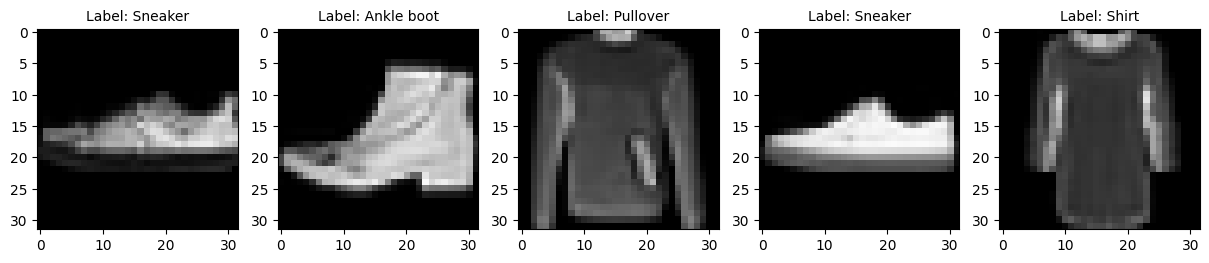

In [5]:
# As these are images (28x28) it can be interesting to plot some as images

str2data = {
    "train": train_gen,
    "val": val_gen,
    "test": test_gen
}


def plot_sample(indexs: int = None, data: str = "train", n: int = 2, model: Model = None, preds=None, pred_scores=None):
    gen = str2data[data]
    if indexs is None:
        indexs = np.random.randint(0, len(gen.x), n)
    images, labels = gen.x, gen.y
    labels = np.argmax(labels, axis=1)
    print(f"Images shape: {images.shape}, labels shape: {labels.shape}")
    fig, ax = plt.subplots(1, n, figsize=(n*3, 3), dpi=100)
    for i,idx in zip(range(n),indexs):
        s = f"Label: {class_names[labels[idx]]}"
        if model is not None or preds is not None:
            if model is not None:
                # Reshape the image to fit the model constraints
                image = images[idx].numpy().reshape(1, *input_shape[1:])
                pred = model.predict(image)
                cl, score = class_names[np.argmax(pred)], np.max(pred)
                s_model = (f"Prediction: {cl} ({score:.3f})")
            elif preds is not None:
                cl, score = class_names[preds[idx]], pred_scores[idx]
                s_model = (f"Prediction: {cl} ({score:.3f})")
            # The text should be below the image
            ax[i].text(0.5, -0.1, s_model, ha='center', transform=ax[i].transAxes,
                       color='red' if cl != class_names[labels[idx]] else 'green')
            ax[i].axis('off')
        ax[i].imshow(images[idx], cmap='gray')
        ax[i].set_title(s)
        # Font size
        ax[i].title.set_fontsize(10)
        ax[i].grid(False)


plot_sample(data="train", n=5)


# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a strating point. A good modell is expected to have 5-50 times as many parameters!

In [6]:
str2backbone = {
    "vgg16": VGG16,
    "xception": Xception,
    "inception": InceptionV3,
    "resnet50": ResNet50,
    "inception_resnet": InceptionResNetV2,
}

def get_backbone(backbone:str="VGG16",output_block:str=None, trainable:bool=False):
    # Extract the VGG16 backbone up to the specified output block
    backbone_model = str2backbone[backbone](weights='imagenet', include_top=False, input_shape=input_shape[1:])
    backbone_model.trainable = trainable
    inp = backbone_model.input
    if output_block is None:
        output = backbone_model.output
    else:
        output = backbone_model.get_layer(output_block).output
    return inp, output

# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

# Run the training

In [7]:
epochs = 15  # Number of epoch to run
batch_size = 64  # Mini batch size


def train_model(model: Model,
                epochs: int,
                batch_size: int,
                train_gen: MyGenerator,
                val_gen: MyGenerator,
                callbacks=None) -> keras.callbacks.History:
    # Train the model.
    history = model.fit(
        train_gen,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=val_gen,
        callbacks=callbacks
    )
    return history


# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

In [8]:
def plot_history(history:keras.callbacks.History, epochs:int):
    epochs = min(epochs, len(history.history['loss']))
    epochrange = range(1, epochs + 1)
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochrange, train_acc, 'bo-', label='Training acc')
    plt.plot(epochrange, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochrange, train_loss, 'bo-', label='Training loss')
    plt.plot(epochrange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# plot_history(history, epochs)

In [9]:
def eval(model:Model, data:str="test"):
    gen = str2data[data]
    # Evaluate the model.
    test_loss, test_acc = model.evaluate(gen)
    print(f'{data} accuracy: {test_acc:.4f}')
    return test_acc

## Theodor Jonsson Code
I'll write my code starting from here to keep the original code intact and to make use it as a reference.

## Model builder
Funktion som bygger modellen givet ett dictionary av parametrar som styr modellens arkitektur och andra hyperparametrar.

In [10]:
str2optim = {
    "adam": Adam,
    "rmsprop": RMSprop,
    "adagrad": Adagrad,
    "sgd":SGD,
}
def new_model(hp:dict)->Model:
    
    inp, out = get_backbone(backbone=hp["backbone"],output_block=hp["backbone_block"], trainable=hp["trainable_backbone"])
    # MLP
    # Backbone:
    backbone = Model(inp, out, name="backbone_"+hp["backbone"])
    x = keras.layers.BatchNormalization(axis=-1)(out)
    x = Flatten()(x)
    mlp_depth = len(hp["dense_units"])
    for i in range(mlp_depth):
        x = Dense(hp["dense_units"][i])(x)
        if i < mlp_depth - 1:
            x = BatchNormalization()(x) if hp["batch_norm"] else x
            x = Activation(hp["activation"])(x)
            x = Dropout(hp["dropout"])(x)
    x = Dense(num_classes, activation='softmax')(x)
    mlp = Model(inputs=out, outputs=x, name="mlp")
    # Full model
    model = Model(inputs=inp, outputs=mlp(backbone(inp)), name="full_model")
    optim = str2optim[hp["optimizer"]](learning_rate=hp["learning_rate"], decay=hp["weight_decay"], clipnorm=hp["clip_norm"])
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    return model

In [11]:

hp = {
  "dropout":0.10,
  "batch_norm":True,
  "optimizer":"adam",
  "learning_rate":0.01,
  "weight_decay":0.00,
  "clip_norm":1,
  "activation":"selu",
  "dense_units": [32,16],
  "backbone":"vgg16",
  "trainable_backbone":False,
  "backbone_block":"block3_pool"
} # Declare the hyperparameters of the model

model = new_model(hp)
# Print number of parameters
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
print(f"Number of trainable parameters: {trainable_count:,}")
print(f"Number of non-trainable parameters: {non_trainable_count:,}")
print(f"Number of total parameters: {model.count_params():,}")
# Number of trainable parameters, found this on stackoverflow: https://stackoverflow.com/questions/45046525/how-can-i-get-the-number-of-trainable-parameters-of-a-model-in-keras
epochs = 40
batch_size = 1024
model_dir = "models"
name = "model_vgg16"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr, model_checkpoint,early_stopping]


Number of trainable parameters: 132,378
Number of non-trainable parameters: 1,736,064
Number of total parameters: 1,868,442


In [12]:
model.summary(expand_nested=True)

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 backbone_vgg16 (Functional)  (None, 4, 4, 256)        1735488   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 32, 32, 3)]       0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 32, 32, 64)        1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 32, 32, 64)        36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 16, 16, 64)      0         |
|                                                               |
| block2_conv1 (Conv2D)     (None, 16, 16, 128)       73

Ovan kan man se en visualisering av beräkningsgrafen för modellen. Hjälper att visualisera hur modellen för att se att den är korrekt byggd.

In [13]:
history = train_model(model, epochs, batch_size, train_gen, val_gen, callbacks=callbacks)

Epoch 1/40


2023-04-20 20:25:38.907561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-20 20:25:39.457991: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


46/47 [============================>.] - ETA: 0s - loss: 0.5873 - categorical_accuracy: 0.8022
Epoch 1: val_loss improved from inf to 0.54507, saving model to models/model_vgg16/model.h5
47/47 [==============================] - 4s 40ms/step - loss: 0.5810 - categorical_accuracy: 0.8041 - val_loss: 0.5451 - val_categorical_accuracy: 0.8587 - lr: 0.0100
Epoch 2/40
46/47 [============================>.] - ETA: 0s - loss: 0.2970 - categorical_accuracy: 0.8928
Epoch 2: val_loss improved from 0.54507 to 0.39725, saving model to models/model_vgg16/model.h5
47/47 [==============================] - 1s 28ms/step - loss: 0.2961 - categorical_accuracy: 0.8933 - val_loss: 0.3973 - val_categorical_accuracy: 0.8690 - lr: 0.0100
Epoch 3/40
46/47 [============================>.] - ETA: 0s - loss: 0.2547 - categorical_accuracy: 0.9096
Epoch 3: val_loss improved from 0.39725 to 0.26667, saving model to models/model_vgg16/model.h5
47/47 [==============================] - 1s 28ms/step - loss: 0.2545 - cate

In [14]:
model = load_model(os.path.join(model_path, "model.h5"))
test_accuarcy = eval(model, "test")
n_parameters = model.count_params()
print(f"Number of parameters: {n_parameters:,}")

10/10 [==============================] - 1s 38ms/step - loss: 0.2242 - categorical_accuracy: 0.9257
test accuracy: 0.9257
Number of parameters: 1,868,442


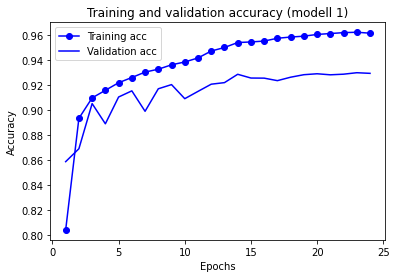

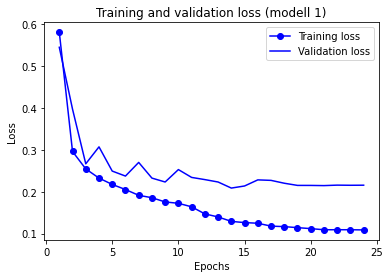

In [15]:
plot_history(history, epochs)

På historiken ovan ser man tydligt att modellen övertränats. Detta är ett problem som återgärdas med hjälp av hyperparametersökning.

# Auto-tune the model
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

# NOTE
Jag använde hyperparametersökning för att hitta de bästa parametrarna för modellen med VGG16 som basstruktur.

In [16]:
# Get Keras Tuner (if in colab)
import sys
if 'google.colab' in sys.modules:
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization
import kerastuner as kt

Keras Tuner version: 1.3.0


/tmp/ipykernel_23795/146912041.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [17]:
# Possible combinations of number of units in the dense layers (MLP after feature extraction)
dense_combs = [[128, 64], [64, 32], [128, 32, 16]]

def build_model_MyModel(hp):
    hp_dropout = hp.Choice('dropout', [0.05, 0.1, 0.15])  # Dropout rate
    # Whether to use batch normalization
    hp_batch_norm = hp.Choice('batch_norm', [False, True])
    hp_optimizer = hp.Choice(
        'optimizer', ['adam', 'rmsprop', 'adagrad'])  # Optimizer
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    hp_weight_decay = hp.Choice('weight_decay', [1e-2, 1e-3, 1e-4])
    hp_clip_norm = hp.Choice('clip_norm', [1.0, 2.0, 10.0])
    hp_activation = hp.Choice(
        'activation', ['relu', 'selu'])  # Activation function
    hp_backbone_block = hp.Choice('backbone_block', [
                                  'block3_pool', 'block4_pool'])  # Which block of the backbone to use
    hp_dense_units = dense_combs[hp.Choice('dense_units', [i for i in range(
        len(dense_combs))])]  # Choose the dense combination, i.e. how many dense layers
    hyperparams = {
        "dropout": hp_dropout,
        "batch_norm": hp_batch_norm,
        "optimizer": hp_optimizer,
        "learning_rate": hp_learning_rate,
        "weight_decay": hp_weight_decay,
        "clip_norm": hp_clip_norm,
        "activation": hp_activation,
        "dense_units": hp_dense_units,
        "backbone": "vgg16",
        "backbone_block": hp_backbone_block,
        "trainable_backbone": False
    }
    # Build and compile the model using the model builder function.
    model = new_model(hyperparams)
    return model


In [18]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 45         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [19]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 512, 2048, step=512, default=1024)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [20]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel,
    max_trials=MAX_TRIALS,
    objective='val_categorical_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST_Lab2'
)

In [21]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 20   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=7, restore_best_weights = True)
tuner.search(train_gen, 
             epochs=noepochauto,
             validation_data=val_gen, 
             callbacks=[es])

Trial 45 Complete [00h 00m 56s]
val_categorical_accuracy: 0.9252916574478149

Best val_categorical_accuracy So Far: 0.932875007390976
Total elapsed time: 00h 42m 26s
INFO:tensorflow:Oracle triggered exit


## Hyperparameter search
Sökningen gjordes med en Nvidia 3060 Ti och ca 44 minuter att testa 45 olika kombinationer av hyperparametrar (MAX_TRIALS=45). Varje modell tränades i 20 iterationer (noepochauto=20) och den bästa modellen valdes baserat på valideringsnoggrannheten. Denna modell uppnådde en valideringsnoggrannhet på ca 93.0% och 92.1% testnoggrannhet.

In [22]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print(f"{keys}:{values}")
    
model.summary()

dropout:0.05
batch_norm:1
optimizer:adam
learning_rate:0.01
weight_decay:0.01
clip_norm:1.0
activation:selu
backbone_block:block3_pool
dense_units:0
batch_size:2048
Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 backbone_vgg16 (Functional)  (None, 4, 4, 256)        1735488   
                                                                 
 mlp (Functional)            (None, 10)                534858    
                                                                 
Total params: 2,270,346
Trainable params: 534,090
Non-trainable params: 1,736,256
_________________________________________________________________


## Code to explore the n-best models

## Resultatet av de 5 bästa modellerna (baserat på valideringsnoggrannheten)

In [23]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      if isinstance(values,(int,float)):
        print('%15.4g ' %(values), end = '')
      else:
        print(f"{values:<15}",end="")
    # end this line and start the trail
    print()

Test accuracy         dropout      batch_norm       optimizer   learning_rate    weight_decay       clip_norm      activation  backbone_block     dense_units      batch_size 

          0.928            0.15               1 adam                      0.01            0.01               1 relu           block3_pool                  0             512 
          0.928            0.15               1 adam                      0.01            0.01               1 relu           block3_pool                  2            2048 
          0.926            0.15               1 adam                      0.01            0.01               1 selu           block3_pool                  2             512 
          0.925             0.1               1 adam                      0.01            0.01              10 relu           block3_pool                  2            1024 
          0.922            0.05               1 adam                      0.01            0.01               1 selu           bl

Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation. 

# With our found hyperparameters, continue training

In [24]:
# Fine-tune the model using the best parameters found as we might not be fully trained
best_model = tuner.get_best_models(num_models=1)[0]

epochs = 60      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

In [25]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
# Print the optimal tunable hyperparameters
for hp, value in best_hyperparameters.values.items():
    print(f'{hp}: {value}')

dropout: 0.15
batch_norm: 1
optimizer: adam
learning_rate: 0.01
weight_decay: 0.01
clip_norm: 1.0
activation: relu
backbone_block: block3_pool
dense_units: 0
batch_size: 512


<!--
dropout: 0.1
batch_norm: 1
optimizer: adam
learning_rate: 0.001
weight_decay: 0.001
clip_norm: 2.0
activation: relu
backbone_block: block3_pool
dense_units: 1
batch_size: 1536
 -->
<!-- dropout: 0.05
batch_norm: 1
optimizer: adam
learning_rate: 0.01
weight_decay: 0.01
clip_norm: 1.0
activation: relu
backbone_block: block3_pool
dense_units: 0
batch_size: 512 -->

| Hyperparameter | Value |
| --- | --- |
| dropout | 0.05 |
| batch_norm | 1 |
| optimizer | adam |
| learning_rate | 0.01 |
| weight_decay | 0.01 |
| clip_norm | 1.0 |
| activation | relu |
| backbone_block | block3_pool |
| dense_units | [128, 32] |
| batch_size | 512 |




## Fortsatt träning av den bästa modellen. OBS! Följande Block kördes två gånger.
Vidare träning med en inlärningshastighet anpassas med hjälp av `ReduceLROnPlateau` callback för att adaptivt minska inlärningshastigheten när träningen stagnar. Detta gör att vi kan öka antalet epoker utan att träningen stagnerar, dock kan det öka risken för överträning.

In [26]:

history = best_model.fit(
  train_gen,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=val_gen,
  initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 21/60
46/47 [============================>.] - ETA: 0s - loss: 0.1030 - categorical_accuracy: 0.9635
Epoch 21: val_loss improved from 0.20866 to 0.20174, saving model to models/model_vgg16/model.h5
47/47 [==============================] - 2s 32ms/step - loss: 0.1032 - categorical_accuracy: 0.9634 - val_loss: 0.2017 - val_categorical_accuracy: 0.9301 - lr: 0.0100
Epoch 22/60
46/47 [============================>.] - ETA: 0s - loss: 0.0974 - categorical_accuracy: 0.9659
Epoch 22: val_loss did not improve from 0.20174
47/47 [==============================] - 1s 27ms/step - loss: 0.0978 - categorical_accuracy: 0.9657 - val_loss: 0.2034 - val_categorical_accuracy: 0.9299 - lr: 0.0100
Epoch 23/60
46/47 [============================>.] - ETA: 0s - loss: 0.0921 - categorical_accuracy: 0.9676
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 23: val_loss did not improve from 0.20174
47/47 [==============================] - 1s 27ms/step - loss: 0.0921 - cate

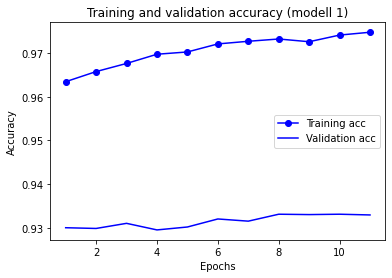

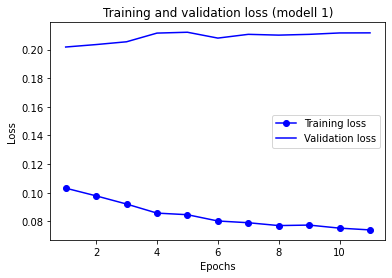

In [27]:
plot_history(history,epochs-noepochauto)

In [28]:
# Evaluate the model.
test_loss, test_acc = best_model.evaluate(test_gen)
print('Test accuracy: %.3f' % test_acc)
val_acc = eval(best_model,"val")
best_model.save("output/FashionMNIST/best_model.h5")

10/10 [==============================] - 0s 20ms/step - loss: 0.2061 - categorical_accuracy: 0.9301
Test accuracy: 0.930
12/12 [==============================] - 0s 20ms/step - loss: 0.2017 - categorical_accuracy: 0.9301
val accuracy: 0.9301


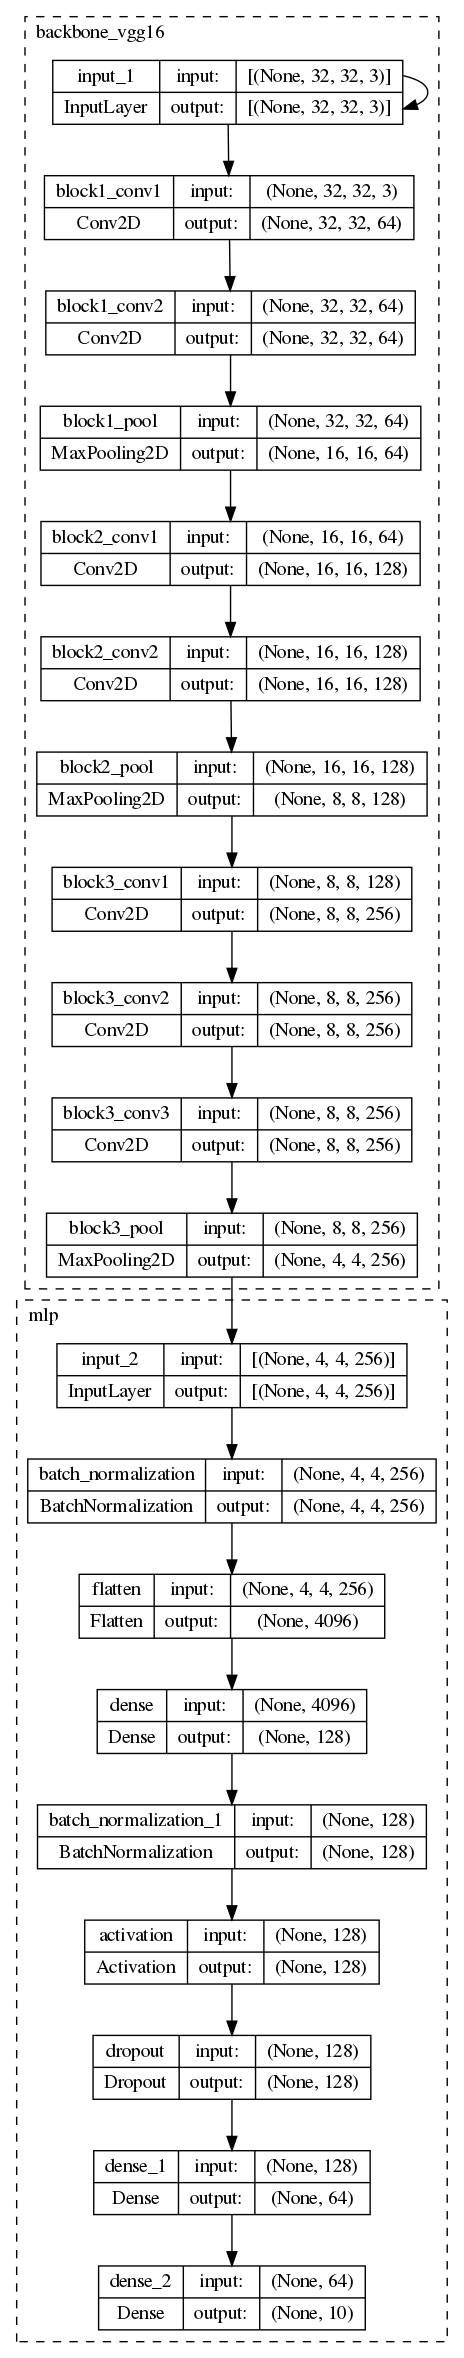

In [29]:
# See what we got and how many parameters are used
plot_model(best_model, show_shapes=True, show_layer_names=True,expand_nested=True, dpi=100)

In [30]:
best_model.summary(expand_nested=True)

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 backbone_vgg16 (Functional)  (None, 4, 4, 256)        1735488   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 32, 32, 3)]       0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 32, 32, 64)        1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 32, 32, 64)        36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 16, 16, 64)      0         |
|                                                               |
| block2_conv1 (Conv2D)     (None, 16, 16, 128)       73

## Resultat Tuning


### Bayesiansk optimering
Prestanda för den bästa modellen som hittades med hjälp av bayesiansk optimering.
| Data | Noggrannhet (%) |
|---|---|
|Test| 93.4|
|Validering| 93.4|

### Modellens arkitektur
Modellens basarkitektur är VGG16 till och med `block3_pool`. Vid denna punk har bilden omvandlats till en 4 x 4 x 256 representation av bilden. Denna representation omvandals sedan till en vektor med $4096$ dimensioner. Basstrukturen av modellen är frusen under träningen och det enda som tränats är den nya klassificeringsdelen av modellen. Jag använde en arkitektursökning blandat med hyperparameter sökning för att uppnå ovanstående resultat med en `MLP` som klassificering direkt efter basstrukturen. Denna sökning gjordes med hjälp av `Keras Tuner` och `BayesianOptimization`. Resultatet blev en modell med 2 dolda lager med 128, 64 neuroner respektive. Efter varje dolt lager användes ett `Dropout` lager med drop-rate $0.05$, `BatchNormalization` och `ReLU`.  aktivationsfunktion.

# Prestandard per kategori

In [31]:
# Din kod som utforskar de testfall som missklassificerade
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
best_model = load_model("output/FashionMNIST/best_model.h5")
pred_scores = best_model.predict(test_gen)
preds = np.argmax(pred_scores,axis=-1)
pred_scores = np.max(pred_scores,axis=-1)
test_labels = np.argmax(test_gen.y,axis=-1)
class_report = classification_report(test_labels,preds,output_dict=True,target_names=class_names,digits=3)


10/10 [==============================] - 0s 18ms/step


In [32]:
# Print report as table
!pip install tabulate
from tabulate import tabulate
headers = ["Class","Precision","Recall","F1-score","Support"]
table = []
for key in class_names:
    table.append([key,class_report[key]["precision"],class_report[key]["recall"],class_report[key]["f1-score"]])
    
    
table.sort(key=lambda x: x[3],reverse=True)
table.append(["macro avg",class_report["macro avg"]["precision"],class_report["macro avg"]["recall"],class_report["macro avg"]["f1-score"]])
print(tabulate(table,headers=headers,tablefmt="github",floatfmt=".3f"))


| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Trouser     |       0.992 |    0.987 |      0.989 |
| Sandal      |       0.990 |    0.988 |      0.989 |
| Bag         |       0.978 |    0.993 |      0.986 |
| Ankle boot  |       0.977 |    0.979 |      0.978 |
| Sneaker     |       0.974 |    0.974 |      0.974 |
| Dress       |       0.939 |    0.929 |      0.934 |
| Coat        |       0.881 |    0.903 |      0.892 |
| Pullover    |       0.898 |    0.874 |      0.886 |
| T-shirt/top |       0.862 |    0.896 |      0.878 |
| Shirt       |       0.808 |    0.778 |      0.793 |
| macro avg   |       0.930 |    0.930 |      0.930 |


## Performace across different classes from Lab 1 (CNNs)
| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Trouser     |    0.993 |    0.986 |   0.989    |
| Sandal      |    0.986 |    0.986 |   0.986    |
| Bag         |    0.984 |    0.988 |   0.986    |
| Ankle boot  |    0.982 |    0.971 |   0.976    |
| Sneaker     |    0.964 |    0.982 |   0.973    |
| Dress       |    0.933 |    0.931 |   0.932    |
| Pullover    |    0.890 |    0.916 |   0.902    |
| Coat        |    0.889 |    0.905 |   0.897    |
| T-shirt/top |    0.879 |    0.861 |   0.870    |
| Shirt       |    0.794 |    0.776 |   0.785    |
| macro avg   |    0.930 |    0.930 |   0.930    |

## Performace across different classes from Lab 2 (Transfer Learning)
| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Sandal      |       0.994 |    0.992 |      0.993 |
| Trouser     |       0.995 |    0.988 |      0.991 |
| Bag         |       0.991 |    0.990 |      0.990 |
| Ankle boot  |       0.989 |    0.975 |      0.982 |
| Sneaker     |       0.972 |    0.987 |      0.980 |
| Dress       |       0.946 |    0.937 |      0.942 |
| Coat        |       0.879 |    0.907 |      0.893 |
| T-shirt/top |       0.878 |    0.896 |      0.887 |
| Pullover    |       0.881 |    0.892 |      0.886 |
| Shirt       |       0.816 |    0.778 |      0.797 |
| macro avg   |       0.934 |    0.934 |      0.934 |

Vi kan se från modellen ovan denna modell presererar jämförbart med modellen från Lab 1 men lite bättre överlag. Liksom i förra labben beror korrelationen mellan missklassifikationerna troligen på följande faktorer:
* T-shirts och toppar har en tydlig liknelse med andra plagg så som skjortor.
* Pull-overs är väldigt lika vissa typer av "coats" och skjortor.

De klasser som presterar bäst var samma som i förra labben och beror liksom då troligen på följande faktorer:

* Byxor har en tydlig form och är inte lika många som andra plagg.
* Sandaler har en tydlig skoform samt att den ofta är ihålig, vilket hjälper till att skilja den från andra skor.
* Väskor har likt byxorna en tydlig form som inte är lika många som andra plagg.

Notera att **F1-score** är en kombination av precision och recall och är en bra mått på hur bra en modell är på att urskilja en klass. Det beräknas med följande formel:

$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$


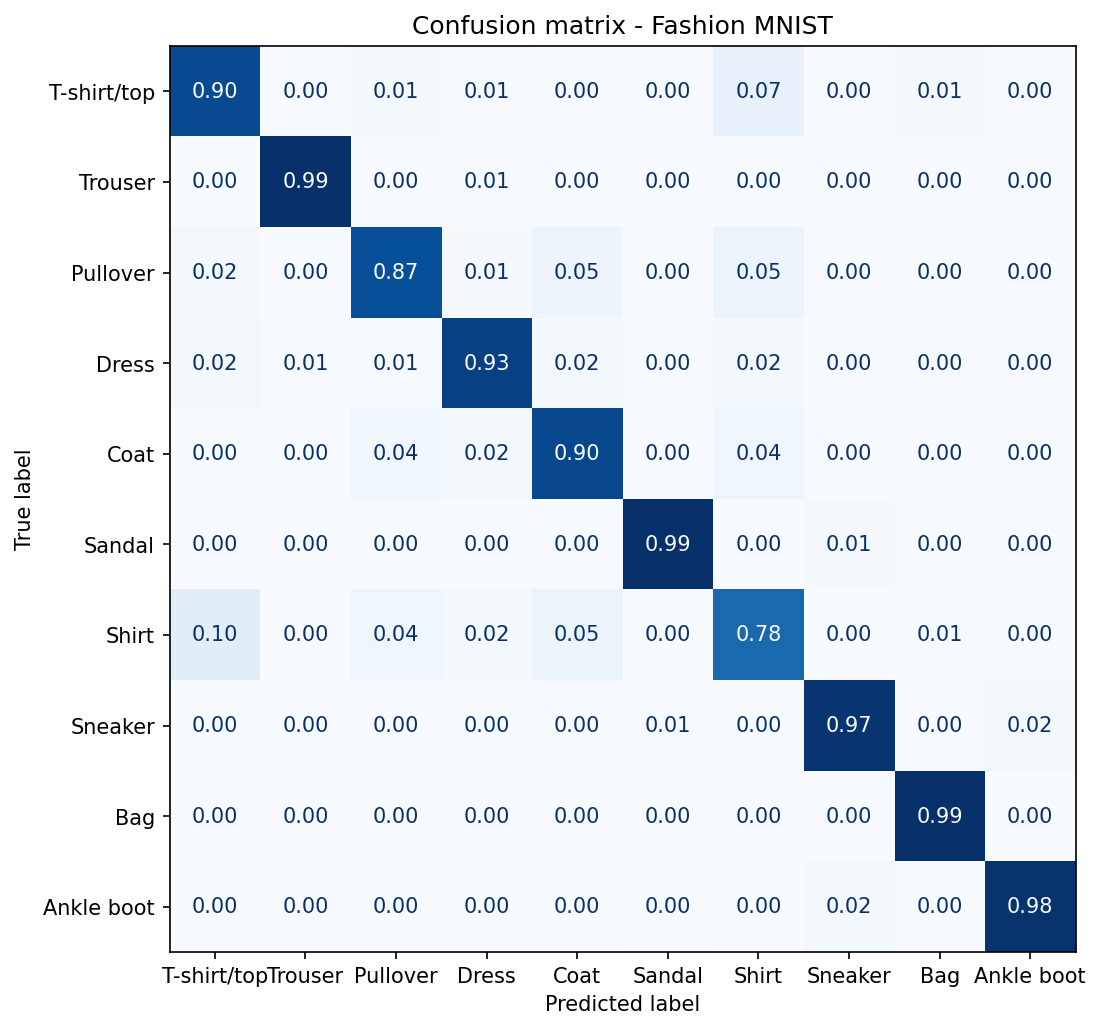

In [33]:
cm = confusion_matrix(test_labels,preds, normalize='true')
fig,ax = plt.subplots(figsize=(8,8),dpi=150)
ax.set_title("Confusion matrix - Fashion MNIST")
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(ax=ax,values_format='.2f',cmap='Blues',colorbar=False)


Precis som i Lab 1 ser vi att modellen lätt förväxlar bilder med `shirt` och `T-shirt/top`

### Missclassified test samples

Images shape: (10000, 32, 32, 3), labels shape: (10000,)


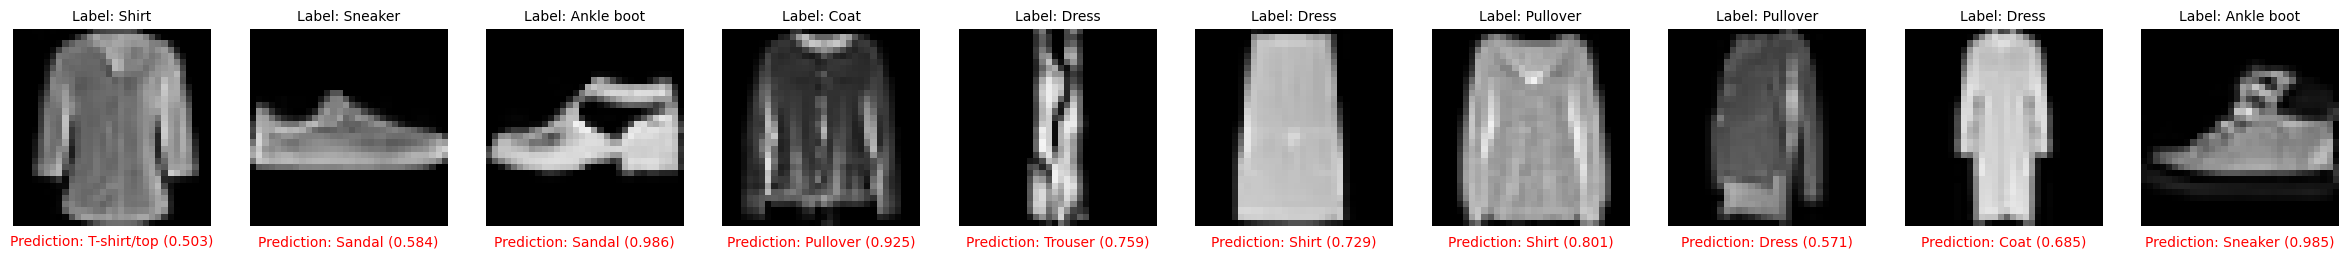

In [34]:
shirt_index = class_names.index("Shirt")
top_index = class_names.index("T-shirt/top")
# samples_idxs = np.where(((test_labels == shirt_index) | (test_labels == top_index)) & (test_labels != preds))[0]
samples_idxs = np.where((test_labels != preds))[0]
plot_sample(samples_idxs, data="test", n=10, preds=preds, pred_scores=pred_scores)

Man kan se att de element som missklassificeras är väldigt lika de som de tros vara av modellen. Man ser till exempel att olika typer av skor mixas ihop, att rockar och klänningar mixas och att tröjor och skjortor mixas. Om vi tagit hänsyn till färger hade troligen modellen preseterat bättre då den typiska färgen för en klänning ofta skiljer sig från den av en rock. Det är också värt att notera att modellen ger en väldigt låg säkerhet på vissa av dessa vilket indikerar på en viss osäkerhet i modellens "edge cases".

## Slumpmässiga exempel

Images shape: (10000, 32, 32, 3), labels shape: (10000,)
1/1 [==============================] - 0s 13ms/step


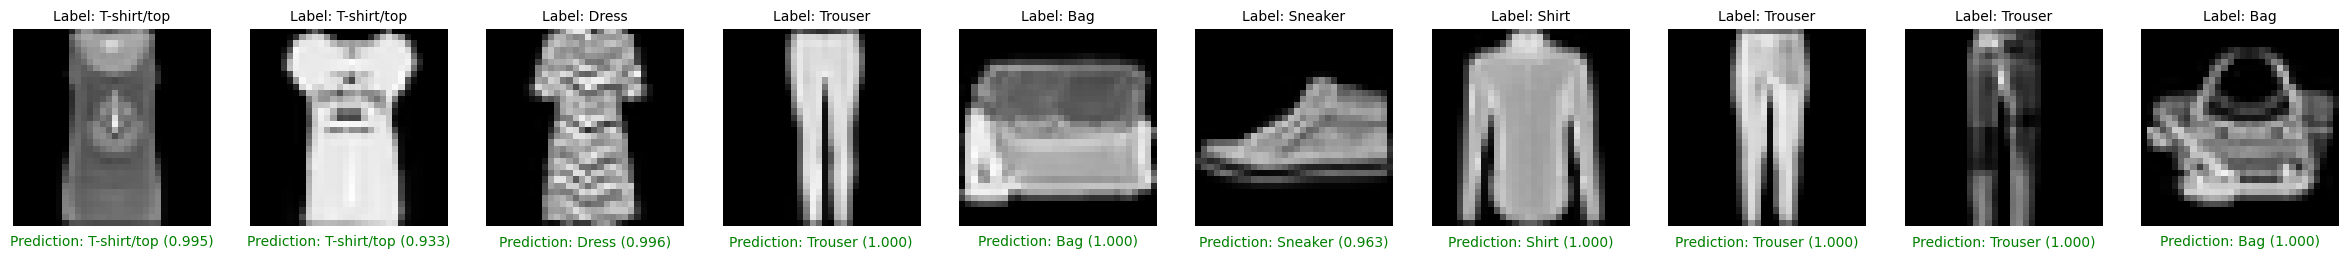

In [35]:
plot_sample(data="test", n=10, model=best_model)

# Del B - För VG
Aktivera träning för vissa av lagrerna i basstrukturen. Jag valde att träna de 4 djupaste lagerna.

In [36]:
hp = dict(best_hyperparameters.values)
hp["backbone"] = "vgg16"
backbone_name = "backbone_"+hp["backbone"]
hp["trainable_backbone"] = False
hp["dense_units"] = dense_combs[hp["dense_units"]]
input_shape = (None,32,32,3)
model = new_model(hp)
backbone = model.get_layer(backbone_name)
# Set last block of the backbone as trainable, the block of a VGG16 is 4 layers when including the pooling layer
for layer in backbone.layers[-4:]:
    layer.trainable = True
model.summary()
model_path = "output/VGG16_block3/"
if not os.path.exists(model_path):
    os.makedirs(model_path,exist_ok=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [model_checkpoint, early_stopping, reduce_lr]
for layer in backbone.layers:
    print(f"{layer.name} is trainable: {layer.trainable}")

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 backbone_vgg16 (Functional)  (None, 4, 4, 256)        1735488   
                                                                 
 mlp (Functional)            (None, 10)                534858    
                                                                 
Total params: 2,270,346
Trainable params: 2,009,418
Non-trainable params: 260,928
_________________________________________________________________
input_3 is trainable: False
block1_conv1 is trainable: False
block1_conv2 is trainable: False
block1_pool is trainable: False
block2_conv1 is trainable: False
block2_conv2 is trainable: False
block2_pool is trainable: False
block3_conv1 is trainable: True
block3_conv2 is trainable: True
block3_conv3 is 

In [37]:
history = model.fit(
  train_gen,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=val_gen,
  callbacks=callbacks
)

Epoch 1/60
45/47 [===========================>..] - ETA: 0s - loss: 0.4940 - categorical_accuracy: 0.8226
Epoch 1: val_loss improved from inf to 0.67141, saving model to output/VGG16_block3/model.h5
47/47 [==============================] - 2s 32ms/step - loss: 0.4852 - categorical_accuracy: 0.8255 - val_loss: 0.6714 - val_categorical_accuracy: 0.8554 - lr: 0.0100
Epoch 2/60
46/47 [============================>.] - ETA: 0s - loss: 0.2733 - categorical_accuracy: 0.8997
Epoch 2: val_loss improved from 0.67141 to 0.35204, saving model to output/VGG16_block3/model.h5
47/47 [==============================] - 1s 28ms/step - loss: 0.2731 - categorical_accuracy: 0.8997 - val_loss: 0.3520 - val_categorical_accuracy: 0.8863 - lr: 0.0100
Epoch 3/60
46/47 [============================>.] - ETA: 0s - loss: 0.2317 - categorical_accuracy: 0.9158
Epoch 3: val_loss improved from 0.35204 to 0.26938, saving model to output/VGG16_block3/model.h5
47/47 [==============================] - 1s 28ms/step - loss:

In [38]:
model = load_model("output/VGG16_block3/model.h5")
test_acc = eval(model,"test")
val_acc = eval(model,"val")

10/10 [==============================] - 0s 20ms/step - loss: 0.2093 - categorical_accuracy: 0.9264
test accuracy: 0.9264
12/12 [==============================] - 0s 20ms/step - loss: 0.1971 - categorical_accuracy: 0.9302
val accuracy: 0.9302


# Träning av basstrukturen - VGG16
Jag använde samma hyperparametrar som jag fann via Bayesiansk optimering under Del A. Jag tränade hela klassificerings delen samt två block av basstrukturen tillhörande modellen. Modellen tränades m.h.a. `Adam` som i tidigare experiment och inkluderade även en inlärningshastighetsreglerare som minskade inlärningshastigheten då validerings förlusten stagnerat. Detta resulterade i att modellen tränades i 2 epoker och fick en valideringsnoggrannhet på 93.17% och en testnoggrannhet på 92.76%.


## Update Generators to use the Xception backbone (71x71) Inputs

In [39]:
def img_transform_X(images):
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
    images = tf.image.resize_with_pad(images, 71, 71, antialias=False)
    return images

# Define a Sequence
class MyGeneratorX(Sequence):
    def __init__(self,
                x_set:Union[np.ndarray,List[np.ndarray]],
                y_set:Union[np.ndarray,List[np.ndarray]],
                batch_size:int,
                pre_process:bool=True,
                categorical:bool=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.pre_process = pre_process
        self.categorical = categorical
        if pre_process:
            self.x = img_transform(self.x)
        if categorical:
            self.y = to_categorical(self.y)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # transform the images to fit the model constraints
        if not self.pre_process:
            x = img_transform_X(batch_x)
        else:
            x = batch_x
        return np.array(x), np.array(batch_y)
    @property # Adding a property decorator to the shape method
    def shape(self):
        return self[0][0].shape
        
batch_size = 128 # Reducing batch size to fit the larger images.
# Generate data streams from data sets
train_gen_x = MyGeneratorX(trainX, trainY, batch_size = batch_size,pre_process=False)
val_gen_x = MyGeneratorX(valX, valY, batch_size = batch_size,pre_process=False)
test_gen_x = MyGeneratorX(test_input, test_label, batch_size = batch_size,pre_process=False)


In [40]:
hp = dict(best_hyperparameters.values)
hp["backbone"] = "xception"
backbone_name = "backbone_"+hp["backbone"]
hp["trainable_backbone"] = True
hp["dense_units"] = dense_combs[hp["dense_units"]]
hp["backbone_block"] = None
input_shape = (None,71,71,3)
model = new_model(hp)
model.summary()
model_path_x = "output/Xception/"
if not os.path.exists(model_path_x):
    print("No model found")
    os.makedirs(model_path_x,exist_ok=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path_x, "model.h5"), monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
callbacks = [model_checkpoint, early_stopping, reduce_lr]
for layer in backbone.layers:
    print(f"{layer.name} is trainable: {layer.trainable}")
history = model.fit(
  train_gen_x,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=val_gen_x,
  callbacks=callbacks
)

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 backbone_xception (Function  (None, 3, 3, 2048)       20861480  
 al)                                                             
                                                                 
 mlp (Functional)            (None, 10)                2377034   
                                                                 
Total params: 23,238,514
Trainable params: 23,179,634
Non-trainable params: 58,880
_________________________________________________________________
input_3 is trainable: True
block1_conv1 is trainable: False
block1_conv2 is trainable: False
block1_pool is trainable: False
block2_conv1 is trainable: False
block2_conv2 is trainable: False
block2_pool is trainable: False
block3_conv1 i

In [41]:
model_x = load_model(model_path_x+"model.h5")
test_acc_x = model_x.evaluate(test_gen_x,verbose=1)[1]
print(f"Test accuracy: {test_acc_x:.3f}")
val_acc_x = model_x.evaluate(val_gen_x,verbose=1)[1]
print(f"Validation accuracy: {val_acc_x:.3f}")

79/79 [==============================] - 6s 69ms/step - loss: 0.3348 - categorical_accuracy: 0.9383
Test accuracy: 0.938
94/94 [==============================] - 6s 66ms/step - loss: 0.3024 - categorical_accuracy: 0.9434
Validation accuracy: 0.943


# Xception prestandard
Xception baserade modellen något bättre än modellen baserad på VGG16. Detta var genom att använda samma hyperparametrar optimerad för VGG16. Detta indikerar på att om vi optimierat modellen för Xception skulle den troligt presterat bättre än VGG16. Xception modellen är betydligt större och har därför en större kapacitet för att lära sig komplexa mönster och en bättre förmåga att generalisera. Jag valde att använda hela Xception modellen för att det fungerade bättre än att använda en lite del av den och att det inte tog så lång tid att tränas. Modellen tränades i 15 epoker och fick en testnoggrannhet på 93.9%.

In [42]:
pred_scores = model_x.predict(test_gen_x)
preds = np.argmax(pred_scores,axis=-1)
pred_scores = np.max(pred_scores,axis=-1)
test_labels = np.argmax(test_gen_x.y,axis=-1)
class_report_x = classification_report(test_labels,preds,output_dict=True,target_names=class_names,digits=3)
table = []
for key in class_names:
    table.append([key,class_report_x[key]["precision"],class_report_x[key]["recall"],class_report_x[key]["f1-score"]])
    
    
table.sort(key=lambda x: x[3],reverse=True)
table.append(["macro avg",class_report_x["macro avg"]["precision"],class_report_x["macro avg"]["recall"],class_report_x["macro avg"]["f1-score"]])
print(tabulate(table,headers=headers,tablefmt="github",floatfmt=".3f"))


79/79 [==============================] - 6s 65ms/step
| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Trouser     |       0.996 |    0.986 |      0.991 |
| Sandal      |       0.987 |    0.991 |      0.989 |
| Bag         |       0.988 |    0.989 |      0.989 |
| Ankle boot  |       0.981 |    0.967 |      0.974 |
| Sneaker     |       0.968 |    0.978 |      0.973 |
| Dress       |       0.932 |    0.942 |      0.937 |
| Pullover    |       0.930 |    0.910 |      0.920 |
| Coat        |       0.903 |    0.915 |      0.909 |
| T-shirt/top |       0.884 |    0.882 |      0.883 |
| Shirt       |       0.816 |    0.823 |      0.819 |
| macro avg   |       0.938 |    0.938 |      0.938 |


## Resultat Xception

| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Bag         |       0.992 |    0.991 |      0.991 |
| Trouser     |       0.997 |    0.986 |      0.991 |
| Sandal      |       0.989 |    0.993 |      0.991 |
| Sneaker     |       0.969 |    0.980 |      0.975 |
| Ankle boot  |       0.983 |    0.966 |      0.974 |
| Dress       |       0.930 |    0.935 |      0.933 |
| Pullover    |       0.920 |    0.915 |      0.917 |
| Coat        |       0.896 |    0.912 |      0.904 |
| T-shirt/top |       0.887 |    0.889 |      0.888 |
| Shirt       |       0.824 |    0.819 |      0.821 |
| macro avg   |       0.939 |    0.939 |      0.939 |

Modellen presterar bättre på nästintill alla klasser och har även mindre skillnad per klass.


# Slutgiltig Analys

## Del A
Inledningsvis testades en modell med 1,868,442 parametrar varav 132,378 var träningsbara. Dessa parametrar befann sig i det träningsbara klassificerings blocket som avslutade modellen. Denna modell presterade relativt bra med ca 92% i testnoggrannhet. För att förbättra modellen använde jag en kombination av arkitekturssökning och hyperparametersökning. De funna parametrarna användes för att träna vidare en modell presterade bättre än den första modellen. Den nya modellen hade 2,270,346 parametrar varav 534,090 var träningsbara. Denna modell presterade bättre än den första modellen med ca 92.8% i testnoggrannhet. Dessa modeller använde ett fruset basblock som bestod av en viss del av VGG16 modellen. Under denna del av labben var denna del helt frusen.
| Total params | Trainable params | Non-trainable params |
|--------------|------------------|----------------------|
| 2,270,346    | 534,090          | 1,736,256            |
## Del B
Under del B var inte längre basstrukturen frusen och tränades samtidigt som klassificerings blocket. Dessa modeller preseterade varierande beroende på hur stor de av basstrukturen som var frusen. Bästa resultaten fann jag då de tidigare lagren av basstrukturen var frusna medan djupare lager var träningsbara. Detta beror troligen på att det faktum att tidigare lager av faltningsnät detekterar grundläggande egenskaper så som linjer, kanter och kontraster medan djupare lager visats detekter med komplexa och problemsberoende egenskaper. Detta indikerar på att det vore mer lönsamt att anpassa de djupa lagrerna efter det aktuella problemet och behålla de tidigare lagrena frusna. Denna modell har samma struktur och därav samma antal parametrar totalt men andelen träningsbara skiljer sig från den i del A:
<!-- Total params: 2,270,346
Trainable params: 2,009,418
Non-trainable params: 260,928 -->
| Total params | Trainable params | Non-trainable params |
|--------------|------------------|----------------------|
| 2,270,346    | 2,009,418        | 260,928              |

Denna modell presterade i paritet med modellen i del A.
## Del X
Att använda Xception som basstruktur fungerade bättre än VGG16. Denna modell blev dock betydligt större och tog därav längre tid att träna. Denna träningsprocess använde samma hyperparametrar som del A och B men ökade testnoggrannheten till 93.9%. 
<!-- Total params: 23,238,514
Trainable params: 23,179,634
Non-trainable params: 58,880 -->
| Total params | Trainable params | Non-trainable params |
|--------------|------------------|----------------------|
| 23,238,514   | 23,179,634       | 58,880               |

